In [1]:
import pandas as pd
import ndlib
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from fg import FactorGraph
from st import SparseTensor
import sys

# Generate Epidemics

In [119]:
import networkx as nx
N_pop = 1000
d_tab = [5,10]
seed = 0 # setting seed everywhere for reproducibility TBD
T = 20 # generate contact from 0 to T-1
lamb_tab = [0.1,0.5]
ps_tab = [0.05,0.1]

In [120]:
def generate_contacts_rnd(t_limit, lambda_, d, N):
    contacts = []
    for t in range(t_limit):
        for j in range(1,int((N+2)/2)):
            contacts.append((0, j, t, lambda_))
            contacts.append((j, 0, t, lambda_))
    return contacts

In [121]:
def eta(t0,ps,lamb,d):
    if t0 == 0:
        return 1 
    else:
        S = np.array([(1-lamb)**(t0-1-i)*eta(i,ps,lamb,d) for i in range(1,t0) ])
        return ( ps*(1-lamb)**t0 + (1-ps)*((1-lamb)**(t0-1) + lamb*sum(S)) )**(d-1)

In [122]:
l_d = len(d_tab)
l_l = len(lamb_tab)
l_p = len(ps_tab)
tol = 1e-14
m_pop = np.zeros((l_p,l_l,l_d,T+2,T+2))
m_an = np.zeros((l_p,l_l,l_d,T+2,T+2))
b_pop = np.zeros((l_p,l_l,l_d,T+2))
b_an = np.zeros((l_p,l_l,l_d,T+2))
for i,ps in enumerate(ps_tab):
    for j,lamb in enumerate(lamb_tab):
        for k,d in enumerate(d_tab):
            f = FactorGraph(
                N=N_pop,
                T=T,
                contacts=generate_contacts_rnd(T, lamb, d, N_pop),
                obs=[], #useless
                delta=ps
            )
            while(f.pop_dyn_RRG(c=d) > tol): pass
            m_pop[i][j][k] = f.messages.values[0]
            b_pop[i][j][k] = np.sum(m_pop[i][j][k]*np.transpose(m_pop[i][j][k]), axis=0)*(T+2)*(T+2)
            eta_tab = np.array([eta(t0,ps,lamb,d) for t0 in range(T+1)])
            for ti in range(T):
                for tj in range(-1,T+1):
                    m_an[i][j][k][ti+1,tj+1] = ( (1-ps)/(T+2))*( ((1-lamb)**(ti-1-tj)*(ti-1>tj) + 1*(tj+2>ti))*eta_tab[ti] - ((1-lamb)**(ti-tj)*(ti>tj) + 1*(tj+1>ti))*eta_tab[ti+1] )
            for tj in range(-1,T+1):
                m_an[i][j][k][0,tj+1] = ps/(T+2)
                m_an[i][j][k][-1,tj+1] = ( (1-ps)/(T+2))*((1-lamb)**(T-1-tj)*(T-1>tj) + 1*(tj+2>T))*eta_tab[T] 
            b_an[i][j][k] = np.sum(m_an[i][j][k]*np.transpose(m_an[i][j][k]), axis=0)*(T+2)*(T+2)
        print(f"{i}, {j}, {k}")

            

0, 0, 1
0, 1, 1
1, 0, 1
1, 1, 1


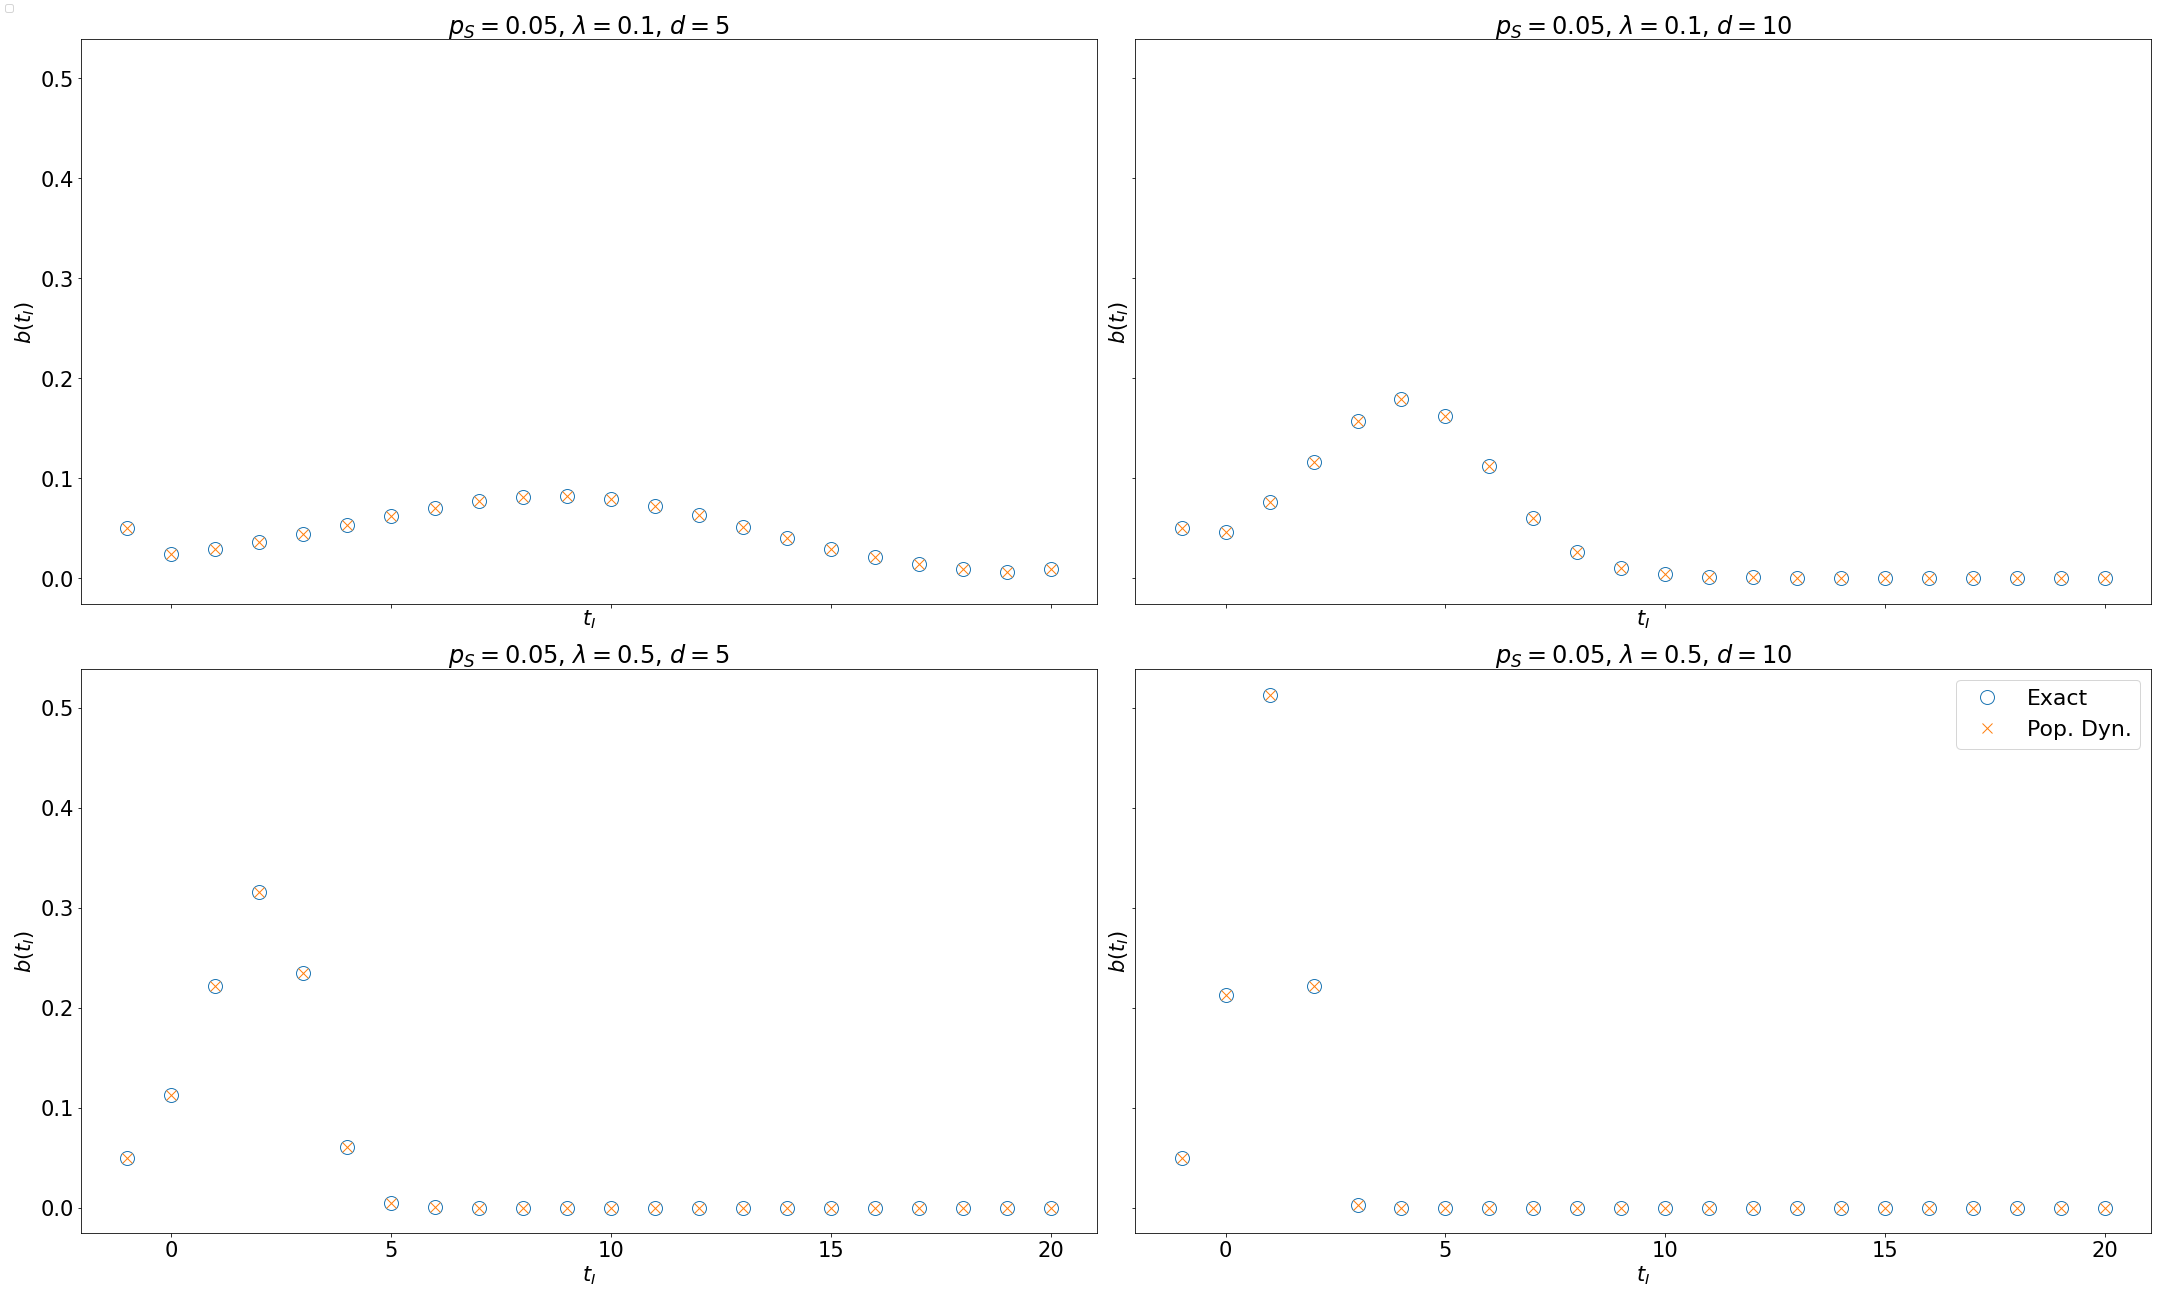

In [160]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, axs = plt.subplots(2,2, figsize=(30,18), sharex=True, sharey=True)
handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left')
for i in range(2):
    for j in range(2):
        axs[i][j].plot(range(-1,T+1), b_an[0][i][j], 'o', fillstyle='none', ms=14, label='Exact')
        axs[i][j].plot(range(-1,T+1), b_pop[0][i][j], 'x', ms=10, label='Pop. Dyn.')
        axs[i][j].set_xlabel(f"$t_I$", fontsize=21)
        axs[i][j].set_ylabel(f"$b(t_I)$",  fontsize=21)
        axs[i][j].set_title(f"$p_S={ps_tab[0]}$, $\lambda={lamb_tab[i]}$, $d={d_tab[j]}$",  fontsize=24)
        axs[i][j].tick_params(labelsize=21)
        #axs[i][j].get_legend().remove()
        #axs[i][j].set_xlim([-1e-5,0.38])
        #axs[i][j].set_ylim([0.004,0.151])

plt.legend(fontsize=22)
# Add a color bar which maps values to colors.
plt.tight_layout()

#fig.savefig(f"PopDyn_Ana.pdf")

In [524]:
m = np.full((T+2,T+2), ps/(T+2) )
for ti in range(T):
    for tj in range(-1,T+1):
        m[ti+1,tj+1] = ( (1-ps)/(T+2))*( ((1-lamb)**(ti-1-tj)*(ti-1>tj) + 1*(tj+2>ti))*eta_tab[ti] - ((1-lamb)**(ti-tj)*(ti>tj) + 1*(tj+1>ti))*eta_tab[ti+1] )
for tj in range(-1,T+1):
    m[-1,tj+1] = ( (1-ps)/(T+2))*((1-lamb)**(T-1-tj)*(T-1>tj) + 1*(tj+2>T))*eta_tab[T] 